In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("rolling_window_sequences.npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17731, 30, 66)
y shape: (17631,)


In [5]:

# Check the length of X and y
print("Length of X:", len(X))
print("Length of y:", len(y))

# Align lengths by truncating to the minimum length if needed
min_len = min(len(X), len(y))
X = X[:min_len]
y = y[:min_len]

# Now split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Example X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])


Length of X: 17731
Length of y: 17631
Train shape: (14104, 30, 66) (14104,)
Val shape: (3527, 30, 66) (3527,)
Example X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 74.  41.  43.  33. 101.]


In [ ]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [6]:
# LSTM Model for RUL Prediction
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

C:\Users\Nanditha Sai\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          33,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - loss: nan - val_loss: nan
Epoch 2/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: nan - val_loss: nan
Epoch 3/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: nan - val_loss: nan
Epoch 4/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - loss: nan - val_loss: nan
Epoch 5/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: nan - val_loss: nan
Epoch 6/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: nan - val_loss: nan
Epoch 7/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: nan - val_loss: nan
Epoch 8/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: nan - val_loss: nan
Epoch 9/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - loss: nan - val_loss: nan
Epoch 10/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: nan - val_loss: nan
Epoch 11/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: nan - val_loss: nan
Epoch 12/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: nan - val_loss: nan
Epoch 13/20
4

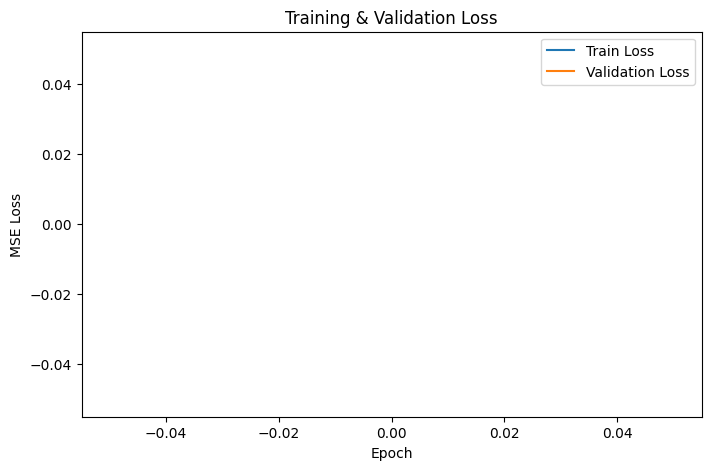

In [10]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


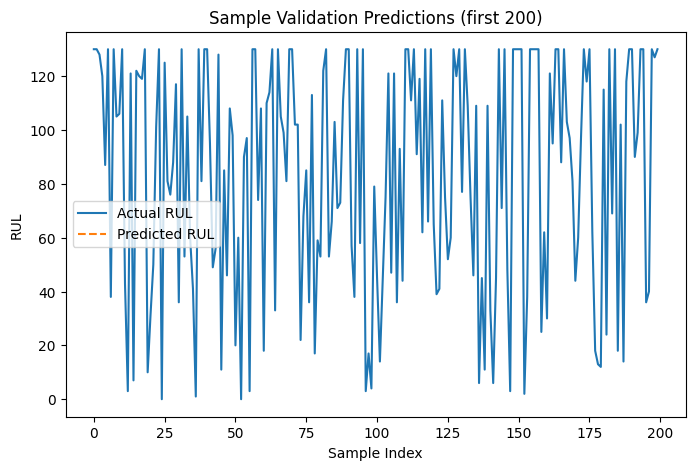

In [11]:
# Verify Model Predictions
val_pred = model.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()